In [2]:
import re

import numpy as np
import pandas as pd
from gymnasium import Env, spaces
from hyperopt.pyll.base import scope
from pyspark.sql import SparkSession
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv

from JapanHorseRaceAnalytics.utilities.base import read_hive_table
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=None,
    # use_cache=False,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# This would mess up the number of horses in the race
# drop from data where meta_int_race_horses_異常区分 != '0'
# data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)

data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-21T22:19:46.657927Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_馬場差,cat_実績_馬場状態コード,cat_実績_レース条件_トラック情報_右左,cat_実績_レース条件_トラック情報_内外,cat_実績_レース条件_種別,cat_実績_レース条件_条件,cat_実績_レース条件_記号,cat_実績_レース条件_重量,cat_実績_レース条件_グレード,num_実績_馬場差,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,...,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,0.0,False,0,False,0,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,None,NaN,21,1,1,12,A3,102,3,None,-18.0,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,04,98102049,2001-08-04 01:45:00,...,-0.036119,-6.733333,-1.066667,-0.733333,-0.010847,0.125590,-18662.266667,-159.225818,-51.509013,01011103,04,2,0,0.0,0,0.000000,False,False,0,0,0.0,0,0.0,9,0,0.0,1,0.111111,False,True,0,0,0.0,0,0.0,01011103,22.800,0.0,NaN,0.0,3.900,北西,2.9300,1010.950,1013.950,60.75,16.875,14.850,None,NaN
1,01011103,09,2.0,200.0,False,0,True,120,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,None,NaN,21,1,1,12,A3,102,3,None,-18.0,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,09,98102902,2001-08-04 01:45:00,...,-0.068150,-9.933333,-1.066667,-1.800000,0.018783,0.125590,-28766.800000,-206.365603,-72.468494,01011103,09,3,0,0.0,2,0.666667,False,True,0,0,0.0,0,0.0,8,0,0.0,3,0.375000,False,True,0,0,0.0,0,0.0,01011103,22.800,0.0,NaN,0.0,3.900,北西,2.9300,1010.950,1013.950,60.75,16.875,14.850,None,NaN
2,01011204,14,6.0,0.0,False,0,False,0,01011204,2001-08-05 02:15:00,01,3,1800,10,1,1,12,A3,102,3,None,NaN,11,1,1,12,A3,102,3,None,-14.0,14,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011204,14,98110058,2001-08-05 02:15:00,...,0.049687,15.769231,6.846154,9.923077,0.137634,0.149950,49377.500000,316.358601,86.088353,01011204,14,4,0,0.0,0,0.000000,False,False,0,0,0.0,0,0.0,10,0,0.0,1,0.100000,False,True,0,0,0.0,0,0.0,01011204,22.300,0.0,NaN,0.0,4.625,北北西,3.1400,1010.325,1013.325,64.00,17.225,15.150,1,30.0
3,01011303,06,3.0,130.0,False,0,True,1090,01011303,2001-08-11 01:45:00,01,3,1700,10,1,1,12,A3,002,3,None,NaN,11,1,1,12,A3,002,3,None,-19.0,13,ダート,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011303,06,98103267,2001-08-11 01:45:00,...,0.063804,7.750000,1.333333,7.916667,0.039064,0.115922,-1223.125000,-199.919166,12.856413,01011303,06,1,0,0.0,0,0.000000,True,True,1,0,0.0,0,0.0,5,0,0.0,0,0.000000,False,True,1,0,0.0,0,0.0,01011303,23.475,0.0,NaN,0.0,0.825,北,1.4350,1009.925,1012.925,65.00,18.725,16.475,None,NaN
4,01011304,07,1.0,510.0,True,230,True,120,01011304,2001-08-11 02:15:00,01,3,2000,10,1,1,12,A3,102,3,None,NaN,11,1,1,12,A3,102,3,None,-17.0,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011304,07,98101610,2001-08-11 02:15:00,...,0.176155,45.066667,15.533333,30.333333,0.169848,0.277041,230843.133333,516.538555,305.098488,01011304,07,1,0,0.0,1,1.000000,True,True,0,0,0.0,0,

In [4]:
class HorseRacingMultiBetEnv(Env):
    metadata = {"render.modes": ["console"]}

    def __init__(
        self,
        data,
        columns,
        race_id_column_name="race_id",
        payout_column_name="payout",
        max_horses=18,
        start_bankroll=10_000,
    ):
        super(HorseRacingMultiBetEnv, self).__init__()
        self.max_horses = max_horses
        self.race_id_column_name = race_id_column_name
        self.payout_column_name = payout_column_name
        self.start_bankroll = start_bankroll
        # Each bit in the binary vector represents a decision to bet on a horse (1) or not (0)
        self.action_space = spaces.MultiBinary(max_horses)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(max_horses, len(columns) - 2), dtype=np.float32
        )
        self.data = data
        self.columns = columns
        self.balance_over_time = [self.start_bankroll]

    def seed(self, seed=None):
        self.np_random, seed = np.random.default_rng(seed), seed
        return [seed]

    def step(self, action):
        assert len(action) == self.max_horses
        current_race_data = self.get_current_race_data()

        # vectorized version
        reward_v = np.sum(current_race_data[:, self.pos_payout] * action) - np.sum(action) * 100

        reward = 0
        for i, bet in enumerate(action):
            if bet:
                reward += current_race_data[i, self.pos_payout] - 100

        self.bankroll += reward
        self.balance_over_time.append(self.bankroll)
        self.select_next_race()
        truncated = self.check_if_truncated()
        terminated = self.check_if_terminated()
        info = {
            "bankroll": self.bankroll,
            "reward": reward,
            "reward_v": reward_v,
            "terminated": terminated,
            "truncated": truncated,
            "race_id": current_race_data[0, self.pos_race_id],
        }
        # print(info)
        if terminated or truncated:
            next_observation = None
        else:
            next_observation = self.get_observation()
        return next_observation, reward, terminated, truncated, info

    def check_if_terminated(self):
        return self.bankroll <= 0

    def check_if_truncated(self):
        return self.current_race_id is None

    def reset(self, seed=None, options=None):
        self.select_initial_race()
        self.bankroll = self.start_bankroll
        return self.get_observation(), {"bankroll": self.bankroll}

    def select_initial_race(self):
        self.current_race_id = self.data[:, self.pos_race_id].min()

    def select_next_race(self):
        gt_current_race_id = self.data[:, self.pos_race_id] > self.current_race_id
        races = self.data[gt_current_race_id]
        if races.shape[0] > 0:
            self.current_race_id = races[:, self.pos_race_id].min()
        else:
            self.current_race_id = None

    @property
    def pos_race_id(self):
        return self.columns.index(self.race_id_column_name)

    @property
    def pos_payout(self):
        return self.columns.index(self.payout_column_name)

    @property
    def pos_features(self):
        result = []
        non_feature_cols = [self.race_id_column_name, self.payout_column_name]
        for i in range(len(self.columns)):
            if self.columns[i] not in non_feature_cols:
                result.append(i)
        return result

    def get_current_race_data(self):
        """
        This method returns the race data with meta features and training features
        """
        race_data = self.data[self.data[:, self.pos_race_id] == self.current_race_id]
        if race_data.shape[0] < self.max_horses:
            padding_size = self.max_horses - race_data.shape[0]
            padding = np.zeros((padding_size, race_data.shape[1]))
            padded_race_data = np.vstack((race_data, padding))
        else:
            padded_race_data = race_data
        return padded_race_data

    def get_observation(self):
        """
        This method returns race data with training features only
        """
        return self.get_current_race_data()[:, self.pos_features].astype(np.float32)

    def render(self, mode="console"):
        # Optional: Implement this method to visualize the state
        # Idea: bankroll over time, bets over time, etc.
        return np.array(self.balance_over_time)

In [5]:
data_ = pd.DataFrame(index=data.index)


# Meta columns
data_["レースキー"] = data["meta_レースキー"]
data_["発走日時"] = data["meta_発走日時"]
data_["馬番"] = data["meta_馬番"]
data_["着順"] = data["meta_着順"]
data_["複勝的中"] = data["meta_複勝的中"]
data_["複勝払戻金"] = data["meta_複勝払戻金"]
data_["血統登録番号"] = data["meta_int_race_horses_血統登録番号"]

# Features
data_["距離"] = data["cat_距離"]
data_["前走距離差"] = data["num_前走距離差"]
data_["年齢"] = data["num_年齢"]
data_["馬体重"] = data["num_馬体重"]
data_["馬体重増減"] = data["num_馬体重増減"]
data_["負担重量"] = data["num_負担重量"]
data_["頭数"] = data["num_頭数"]
data_["トラック種別"] = data["cat_トラック種別"]
data_["一走前着順"] = data["num_一走前着順"]
data_["二走前着順"] = data["num_二走前着順"]
data_["三走前着順"] = data["num_三走前着順"]
data_["四走前着順"] = data["num_四走前着順"]
data_["五走前着順"] = data["num_五走前着順"]
data_["複勝オッズ"] = data["num_事前_複勝オッズ"]


# fmt: off
categories = np.array([
    # ["距離", [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]]
])
category_keys = categories[:, 0] if categories else []
category_values = categories[:, 1] if categories else []
num_cols = [
    # "前走距離差",
    # "年齢",
    # "馬体重増減",
    # "負担重量",
    # "頭数",
    # "一走前着順",
    # "二走前着順",
    # "三走前着順",
    # "四走前着順",
    # "五走前着順",
    # "複勝オッズ",
]
num_null_cols = [
    # "馬体重"  # 95% of 馬体重 null values are where 異常区分 != 0
]
cat_cols = [
    # "トラック種別"
]
meta_cols = ["レースキー", "複勝的中", "複勝払戻金"]
all_cols = category_keys + num_cols + num_null_cols + cat_cols + meta_cols
# fmt: on

preprocessor = ColumnTransformer(
    transformers=[
        # fmt: off
        ("ord", OrdinalEncoder(categories=category_values), category_keys),
        ("num", StandardScaler(), num_cols),
        ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        ("meta", "passthrough", meta_cols)
        # fmt: on
    ],
    remainder="drop",
)

X = data_
y = data_["複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"X_train_prep: {X_train_prep.shape}")
print(f"X_test_prep: {X_test_prep.shape}")

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_5444/726372301.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  category_keys = categories[:, 0] if categories else []
/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_5444/726372301.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  category_values = categories[:, 1] if categories else []


X_train: (857061, 21)
X_test: (214266, 21)
y_train: (857061,)
y_test: (214266,)
X_train_prep: (857061, 3)
X_test_prep: (214266, 3)


In [6]:
def make_env(
    data,
    columns,
    race_id_column_name,
    payout_column_name,
    max_horses,
    start_bankroll,
    rank,
):
    """
    Utility function for multiprocessed env.

    :param data: The dataset to use for training.
    :param columns: List of column names in the dataset.
    :param race_id_column_name: Name of the column containing race IDs.
    :param payout_column_name: Name of the column containing payout information.
    :param max_horses: Maximum number of horses in a race.
    :param start_bankroll: Starting bankroll for the betting model.
    :param rank: Unique identifier for the environment (necessary for seeding).
    :return: A function that returns an environment.
    """

    def _init():
        env = HorseRacingMultiBetEnv(
            data=data,
            columns=columns,
            race_id_column_name=race_id_column_name,
            payout_column_name=payout_column_name,
            max_horses=max_horses,
            start_bankroll=start_bankroll,
        )
        env.seed(rank)
        return env

    return _init

In [8]:
n_envs = 4

env_kwargs = {
    "columns": all_cols,
    "race_id_column_name": "レースキー",
    "payout_column_name": "複勝払戻金",
    "max_horses": 18,
    "start_bankroll": 0,
}

if n_envs == 1:
    # Single environment
    env = make_env(data=X_train_prep, rank=0, **env_kwargs)()
else:
    # Multiple environments
    envs = []
    for i in range(n_envs):
        envs.append(make_env(data=X_train_prep, rank=i, **env_kwargs))
    env = SubprocVecEnv(envs)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000, progress_bar=True)

Using cpu device


Output()

-----------------------------
| time/              |      |
|    fps             | 53   |
|    iterations      | 1    |
|    time_elapsed    | 154  |
|    total_timesteps | 8192 |
-----------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 2           |
|    time_elapsed         | 317         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.084588155 |
|    clip_fraction        | 0.572       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.4       |
|    explained_variance   | 2.62e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.74e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.145      |
|    value_loss           | 3.89e+05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 3           |
|    time_elapsed         | 472         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.087762706 |
|    clip_fraction        | 0.578       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.2       |
|    explained_variance   | -4.41e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.46e+05    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.143      |
|    value_loss           | 2.65e+05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 4          |
|    time_elapsed         | 628        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.06660791 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.8      |
|    explained_variance   | -5.6e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 8.07e+04   |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.133     |
|    value_loss           | 1.73e+05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 5          |
|    time_elapsed         | 782        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.04574028 |
|    clip_fraction        | 0.498      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.4      |
|    explained_variance   | -2.86e-06  |
|    learning_rate        | 0.0003     |
|    loss                 | 5.16e+04   |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.121     |
|    value_loss           | 1.12e+05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 6           |
|    time_elapsed         | 936         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.030858275 |
|    clip_fraction        | 0.432       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.1       |
|    explained_variance   | -1.91e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.85e+04    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.102      |
|    value_loss           | 7.94e+04    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 7           |
|    time_elapsed         | 1090        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.026392179 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.8       |
|    explained_variance   | -1.07e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.25e+04    |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0821     |
|    value_loss           | 5.87e+04    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 8           |
|    time_elapsed         | 1247        |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.024614796 |
|    clip_fraction        | 0.377       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84e+04    |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0722     |
|    value_loss           | 4.55e+04    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 9          |
|    time_elapsed         | 1398       |
|    total_timesteps      | 73728      |
| train/                  |            |
|    approx_kl            | 0.03170745 |
|    clip_fraction        | 0.409      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1      |
|    explained_variance   | -2e-05     |
|    learning_rate        | 0.0003     |
|    loss                 | 2.23e+04   |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.0496    |
|    value_loss           | 4.33e+04   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 10          |
|    time_elapsed         | 1550        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.035970706 |
|    clip_fraction        | 0.45        |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.8        |
|    explained_variance   | -2.97e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.25e+04    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 3.73e+04    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 11          |
|    time_elapsed         | 1701        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.041644964 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.5        |
|    explained_variance   | -7.39e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.09e+04    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 4.12e+04    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 12          |
|    time_elapsed         | 1852        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.017627493 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.3        |
|    explained_variance   | -7.15e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.45e+04    |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 3.95e+04    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 13          |
|    time_elapsed         | 2004        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.018052407 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.21       |
|    explained_variance   | -1.79e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76e+04    |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00845    |
|    value_loss           | 3.89e+04    |
-----------------------------------------


<Axes: >

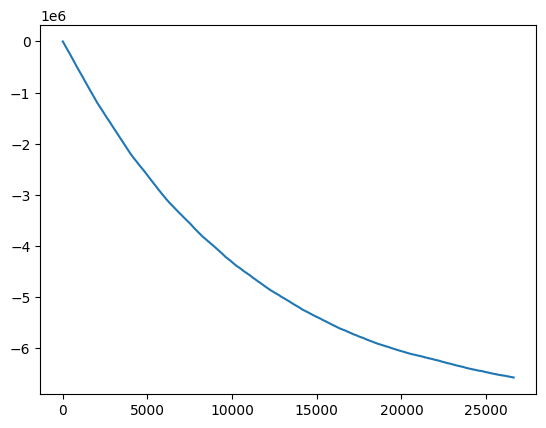

In [17]:
# model.env.get_attr("bankroll")
pd.Series(np.cumsum(model.env.get_attr("balance_over_time")[0])).plot()
# model.env.get_attr("bankroll")

In [ ]:
# env = HorseRacingMultiBetEnv(
#     data=X_train_prep,
#     columns=all_cols,
#     race_id_column_name="レースキー",
#     payout_column_name="複勝払戻金",
#     max_horses=18,
#     start_bankroll=1_000_000,
# )

# # n_steps refers to the number of samples collected before each update.
# # The total number of samples is n_steps * n_envs where n_envs is the number of parallel environments.
# model = PPO("MlpPolicy", env, verbose=0)

# # total_timesteps refers to the total number of samples to train on, not the number of timesteps in an episode.
# # It is used to control the total amount of training data the agent sees during the training process.
# total_timesteps = len(np.unique(X_train_prep[:, all_cols.index("レースキー")]))
# model.learn(total_timesteps=total_timesteps, progress_bar=True)

In [ ]:
test_env = HorseRacingMultiBetEnv(
    data=X_test_prep,
    columns=all_cols,
    race_id_column_name="レースキー",
    payout_column_name="複勝払戻金",
    max_horses=18
)

# Reset the test environment to start a new episode
obs, _ = test_env.reset()
terminated = False
truncated = False
print(obs.dtype)

while not terminated and not truncated:
    # Predict the action with the highest probability
    action, _states = model.predict(obs, deterministic=True)
    
    # Perform the action in the environment and move to the next state
    obs, reward, terminated, truncated, info = test_env.step(action)
    print(info)
    
    # Optionally, render the environment or perform additional analysis
    # test_env.render()
